In [ ]:
# !pip install geopandas
# !pip install networkx
# !pip install torch
# !pip install torch_geometric

In [ ]:
import pandas as pd
import networkx as nx
import geopandas as gpd
from shapely import wkt
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Automated_Traffic_Volume_Counts_20240908.csv')
df.head()


<ipython-input-10-f8d6d10d6347>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Automated_Traffic_Volume_Counts_20240908.csv')


,RequestID,Boro,Yr,M,D,HH,MM,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction
0,32970,Queens,2021,4,30,2,0,0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
1,32970,Queens,2021,4,30,2,15,1,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
2,32970,Queens,2021,4,30,2,30,0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
3,32970,Queens,2021,4,30,2,45,0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB
4,32970,Queens,2021,4,30,3,0,1,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB


In [ ]:
print(df.info())
df['Vol'] = df['Vol'].str.replace(',', '').astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712605 entries, 0 to 1712604
Data columns (total 14 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   RequestID  int64 
 1   Boro       object
 2   Yr         int64 
 3   M          int64 
 4   D          int64 
 5   HH         int64 
 6   MM         int64 
 7   Vol        object
 8   SegmentID  int64 
 9   WktGeom    object
 10  street     object
 11  fromSt     object
 12  toSt       object
 13  Direction  object
dtypes: int64(7), object(7)
memory usage: 182.9+ MB
None


In [ ]:
df = df.rename(columns={'Yr': 'year', 'M': 'month', 'D': 'day', 'HH': "hour", 'MM': 'minutes'})

df['datetime'] = pd.to_datetime(df[['year', 'month', 'day','hour','minutes']], format='%Y-%m-%d-%H-%M')

# Converting WktGeom to geometry
df['geometry'] = df['WktGeom'].apply(wkt.loads)

# Converting to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')


In [ ]:
gdf.head()

,RequestID,Boro,year,month,day,hour,minutes,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction,datetime,geometry
0,32970,Queens,2021,4,30,2,0,0.0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB,2021-04-30 02:00:00,POINT (997407.1 208620.926)
1,32970,Queens,2021,4,30,2,15,1.0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB,2021-04-30 02:15:00,POINT (997407.1 208620.926)
2,32970,Queens,2021,4,30,2,30,0.0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB,2021-04-30 02:30:00,POINT (997407.1 208620.926)
3,32970,Queens,2021,4,30,2,45,0.0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB,2021-04-30 02:45:00,POINT (997407.1 208620.926)
4,32970,Queens,2021,4,30,3,0,1.0,149701,POINT (997407.0998491726 208620.92612708386),PULASKI BRIDGE,Newtown Creek Shoreline,Dead end,NB,2021-04-30 03:00:00,POINT (997407.1 208620.926)


In [ ]:
#Initializing a directed graph
G = nx.DiGraph()

for idx, row in gdf.iterrows():
    # Adding nodes using SegmentID and include the volume and any other attributes
    G.add_node(row['SegmentID'], volume=row['Vol'], boro=row['Boro'], street=row['street'])

# Adding edges with SegmentID and datetime as edge attributes
for idx, row in gdf.iterrows():
    if pd.notna(row['fromSt']) and pd.notna(row['toSt']):
        G.add_edge(row['fromSt'], row['toSt'],
                   segment=row['SegmentID'],
                   datetime=row['datetime'],  # Add datetime as an edge attribute
                   volume=row['Vol'])  # Optionally, volume on the edge as well

# Ensure all nodes have the required attributes (e.g., 'volume')
required_attributes = {'volume', 'boro', 'street'}
for node in G.nodes():
    for attr in required_attributes:
        if attr not in G.nodes[node]:
            if attr == 'volume':
                G.nodes[node][attr] = 0  # Set a default value for missing volume attributes
            else:
                G.nodes[node][attr] = 'Unknown' # Set default for other attributes

In [ ]:
# Number of nodes and edges in the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Degree of each node (number of incoming and outgoing connections)
node_degrees = dict(G.degree())
print("Degree of each node (segment):")
print(node_degrees)

# Checking if the graph is connected
print(f"Is the graph strongly connected? {nx.is_strongly_connected(G)}")


Number of nodes: 6710
Number of edges: 3017
Degree of each node (segment):
{149701: 0, 90610: 0, 158626: 0, 19651: 0, 9009102: 0, 35521: 0, 72596: 0, 178705: 0, 19870: 0, 149966: 0, 49507: 0, 66081: 0, 66303: 0, 156973: 0, 28962: 0, 116319: 0, 146631: 0, 43772: 0, 177615: 0, 66377: 0, 66420: 0, 116408: 0, 172079: 0, 38243: 0, 62117: 0, 132819: 0, 72975: 0, 27774: 0, 156342: 0, 156333: 0, 49568: 0, 49583: 0, 91184: 0, 179041: 0, 179156: 0, 150372: 0, 20063: 0, 20219: 0, 35597: 0, 49993: 0, 72664: 0, 50660: 0, 20222: 0, 116523: 0, 116524: 0, 157039: 0, 28973: 0, 29025: 0, 43798: 0, 11394: 0, 156609: 0, 147124: 0, 239592: 0, 91116: 0, 38367: 0, 27775: 0, 73031: 0, 132866: 0, 91191: 0, 9009104: 0, 158732: 0, 179249: 0, 35619: 0, 50820: 0, 35637: 0, 35648: 0, 35649: 0, 35671: 0, 91229: 0, 91230: 0, 91269: 0, 91271: 0, 91273: 0, 91282: 0, 91303: 0, 91326: 0, 91383: 0, 91384: 0, 72755: 0, 11397: 0, 157065: 0, 11633: 0, 44148: 0, 29120: 0, 11637: 0, 147365: 0, 38371: 0, 27822: 0, 179810: 0, 18

In [ ]:
from torch_geometric.utils import from_networkx
data = from_networkx(G)
print(data)

Data(edge_index=[2, 3017], volume=[6710], boro=[6710], street=[6710], segment=[3017], datetime=[3017], edge_volume=[3017], num_nodes=6710)


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class TrafficGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TrafficGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)  # First GCN layer with 16 hidden units
        self.conv2 = GCNConv(16, out_channels)  # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply the first GCN layer and ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Apply the second GCN layer
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)  # Log softmax for multi-class classification


In [ ]:
data.x = torch.tensor([G.nodes[node]['volume'] for node in G.nodes], dtype=torch.float).unsqueeze(1)  # Node features (e.g., volume)

# Dummy labels for congestion levels
data.y = torch.tensor([0 if G.nodes[node]['volume'] < 100 else 1 for node in G.nodes], dtype=torch.long)  # Labels (binary for low/high congestion)

# Splitting the data into training and test sets
train_mask = torch.rand(len(data.y)) < 0.8  # 80% of data for training
data.train_mask = train_mask
data.test_mask = ~train_mask

# Replace NaN values in data.x with 0
data.x = torch.nan_to_num(data.x, nan=0.0)



Epoch 0, Train Loss: 1.9442, Train Accuracy: 0.6709, Test Loss: 1.4638, Test Accuracy: 0.6783
Epoch 10, Train Loss: 0.7868, Train Accuracy: 0.7159, Test Loss: 0.7529, Test Accuracy: 0.7312
Epoch 20, Train Loss: 0.5274, Train Accuracy: 0.8145, Test Loss: 0.5336, Test Accuracy: 0.8041
Epoch 30, Train Loss: 0.4191, Train Accuracy: 0.9477, Test Loss: 0.4220, Test Accuracy: 0.9035
Epoch 40, Train Loss: 0.3730, Train Accuracy: 0.9365, Test Loss: 0.3682, Test Accuracy: 0.9600
Epoch 50, Train Loss: 0.3287, Train Accuracy: 0.9569, Test Loss: 0.3296, Test Accuracy: 0.9543
Epoch 60, Train Loss: 0.2958, Train Accuracy: 0.9718, Test Loss: 0.2966, Test Accuracy: 0.9721
Epoch 70, Train Loss: 0.2712, Train Accuracy: 0.9697, Test Loss: 0.2719, Test Accuracy: 0.9743
Epoch 80, Train Loss: 0.2514, Train Accuracy: 0.9718, Test Loss: 0.2524, Test Accuracy: 0.9743
Epoch 90, Train Loss: 0.2355, Train Accuracy: 0.9719, Test Loss: 0.2366, Test Accuracy: 0.9728
Epoch 100, Train Loss: 0.2227, Train Accuracy: 0.96

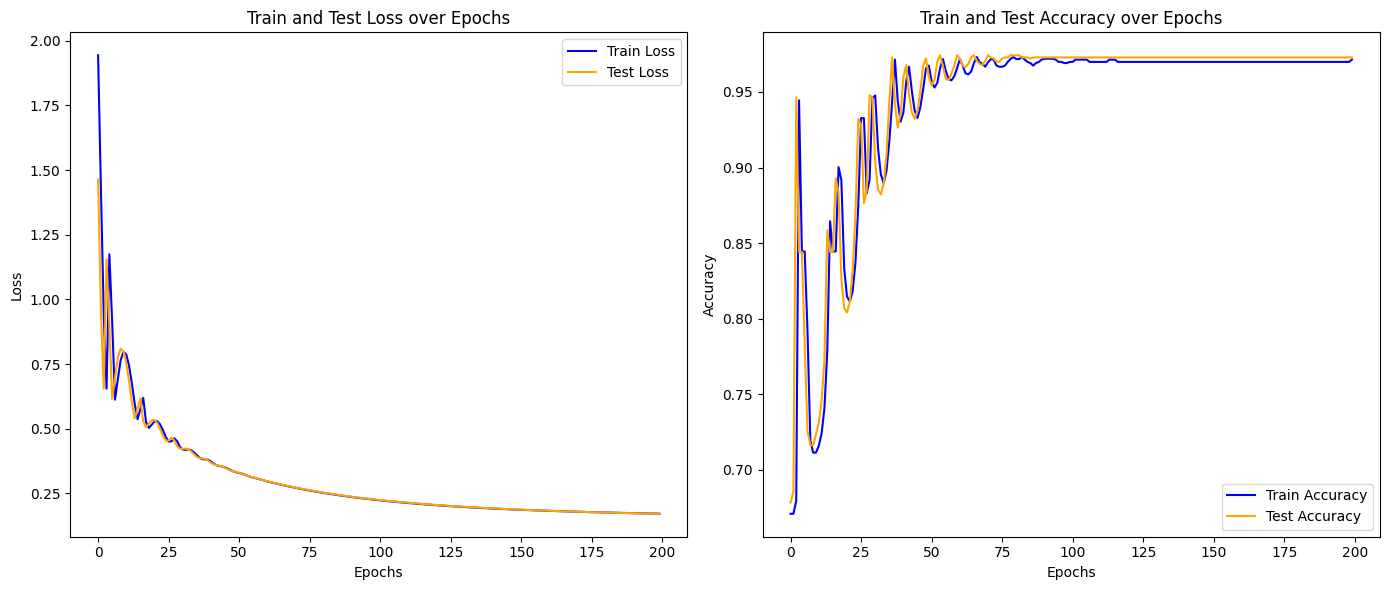

In [ ]:

# Instantiating the model
model = TrafficGNN(in_channels=data.x.shape[1], out_channels=2)  # 2 output classes for congestion levels
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Optimizer

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training function
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out = model(data)  # Forward pass
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Compute training loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update model parameters

    # Calculate training accuracy
    pred = out.argmax(dim=1)
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    train_accuracy = int(correct) / int(data.train_mask.sum())

    return loss.item(), train_accuracy

# Test function to compute both test accuracy and test loss
def test():
    model.eval()
    out = model(data)
    test_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask]).item()  # Compute test loss

    # Calculate test accuracy
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    test_accuracy = int(correct) / int(data.test_mask.sum())

    return test_loss, test_accuracy

# Training loop
for epoch in range(200):  # Train for 200 epochs
    train_loss, train_accuracy = train()
    test_loss, test_accuracy = test()

    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if epoch % 10 == 0:  # Print every 10 epochs
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Final evaluation
final_test_loss, final_test_accuracy = test()
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.4f}')

# Plot the loss and accuracy curves
epochs = range(200)

plt.figure(figsize=(14, 6))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Getting predictions for all nodes
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)  # Predictions as class labels

print(classification_report(data.y.cpu().numpy(), pred.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5666
           1       1.00      0.82      0.90      1044

    accuracy                           0.97      6710
   macro avg       0.98      0.91      0.94      6710
weighted avg       0.97      0.97      0.97      6710



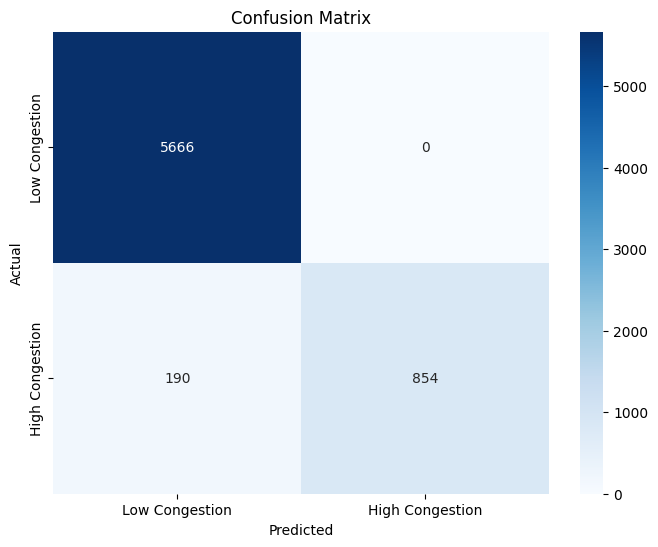

In [ ]:
cm = confusion_matrix(data.y.cpu().numpy(), pred.cpu().numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Low Congestion', 'High Congestion'],
            yticklabels=['Low Congestion', 'High Congestion'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
cm

array([[5666,    0],
       [ 190,  854]])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

auc = roc_auc_score(data.y.cpu().numpy(), probs)
mcc = matthews_corrcoef(data.y.cpu().numpy(), pred.cpu().numpy())

print(f"AUC: {auc:.4f}")
print(f"MCC: {mcc:.4f}")

AUC: 0.9136
MCC: 0.8896


In [ ]:
print(torch.isnan(data.x).any())  # Checking if there are NaNs in the features
print(torch.isinf(data.x).any())  # Checking if there are infinite values in the features
print(torch.isnan(data.y).any())  # Checking if there are NaNs in the labels
print(torch.isinf(data.y).any())  # Checking if there are infinite values in the labels


tensor(False)
tensor(False)
tensor(False)
tensor(False)


In [ ]:
with torch.no_grad():
    gnn_embeddings = model(data)

In [ ]:
node_id_to_index = {node: idx for idx, node in enumerate(G.nodes)}

for edge in G.edges():
    node_from, node_to = edge

    if node_from in node_id_to_index and node_to in node_id_to_index:
        node_from_index = node_id_to_index[node_from]
        node_to_index = node_id_to_index[node_to]

        # Calculating congestion levels
        congestion_level_from = gnn_embeddings[node_from_index].sum().item()
        congestion_level_to = gnn_embeddings[node_to_index].sum().item()

        G[node_from][node_to]['weight'] = (congestion_level_from + congestion_level_to) / 2
    else:
        print(f'Node {node_from} or {node_to} not found in embeddings.')


In [ ]:
# Using NetworkX's pagerank function with the edge weights
page_rank = nx.pagerank(G, weight='weight')

In [ ]:
segment_data = []

# Sorting segments by PageRank score and extract top 50
sorted_segments = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)

for to_st_name, score in sorted_segments[:50]:
    # Finding the rows in the GeoDataFrame (gdf) where 'toSt' matches
    matching_rows = gdf[gdf['toSt'] == to_st_name]

    # If we find matching 'toSt', extract the SegmentID, fromSt, and datetime
    if not matching_rows.empty:
        for idx, row in matching_rows.iterrows():
            # Extract date and time info (assuming 'yr', 'm', 'd', 'HH', 'mm' are available in gdf)
            datetime_value = pd.Timestamp(
                year=int(row['year']),
                month=int(row['month']),
                day=int(row['day']),
                hour=int(row['hour']),
                minute=int(row['minutes'])
            )

            # Append the SegmentID, fromSt, toSt, CongestionScore, and datetime to the list
            segment_data.append({
                'SegmentID': row['SegmentID'],   # Extract SegmentID
                'fromSt': row['fromSt'],         # Extract 'fromSt' name
                'toSt': row['toSt'],             # Extract 'toSt' name
                'CongestionScore': score,        # Use the PageRank score as CongestionScore
                'Datetime': datetime_value       # Add the extracted datetime value
            })

# Converting the collected data into a pandas DataFrame
segment_df = pd.DataFrame(segment_data)


In [ ]:
segment_df.to_csv('congestion_segments_with_fromSt_datetime.csv', index=False)

segment_df.head(10).sort_values('CongestionScore', ascending=False)

,SegmentID,fromSt,toSt,CongestionScore,Datetime
0,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 02:00:00
1,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 02:15:00
2,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 02:30:00
3,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 02:45:00
4,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 03:00:00
5,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 03:15:00
6,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 03:30:00
7,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 03:45:00
8,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 04:00:00
9,149701,Newtown Creek Shoreline,Dead end,0.011673,2021-04-30 04:15:00


In [ ]:
# Sorting segments by PageRank score to identify the most congested streets
sorted_segments = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)
for segment, score in sorted_segments[:3]:
    print(f'Segment {segment}, Congestion Score: {score}')
sorted_segments[:10]

Segment Dead end, Congestion Score: 0.011672881704205657
Segment BOSTON RD, Congestion Score: 0.0035314770613220497
Segment BODY OF WATER, Congestion Score: 0.0024194386418114975


[('Dead end', 0.011672881704205657),
 ('BOSTON RD', 0.0035314770613220497),
 ('BODY OF WATER', 0.0024194386418114975),
 ('CROSS BAY BLVD', 0.0023509200233223174),
 ('BEND', 0.002306051326910086),
 ('Dead End', 0.002139443229274684),
 ('Harlem River Shoreline', 0.00198930479133492),
 ('Flatbush Avenue', 0.0018847147262293406),
 ('Broadway', 0.0018454350424351254),
 ('BROADWAY', 0.0017783844889744324)]

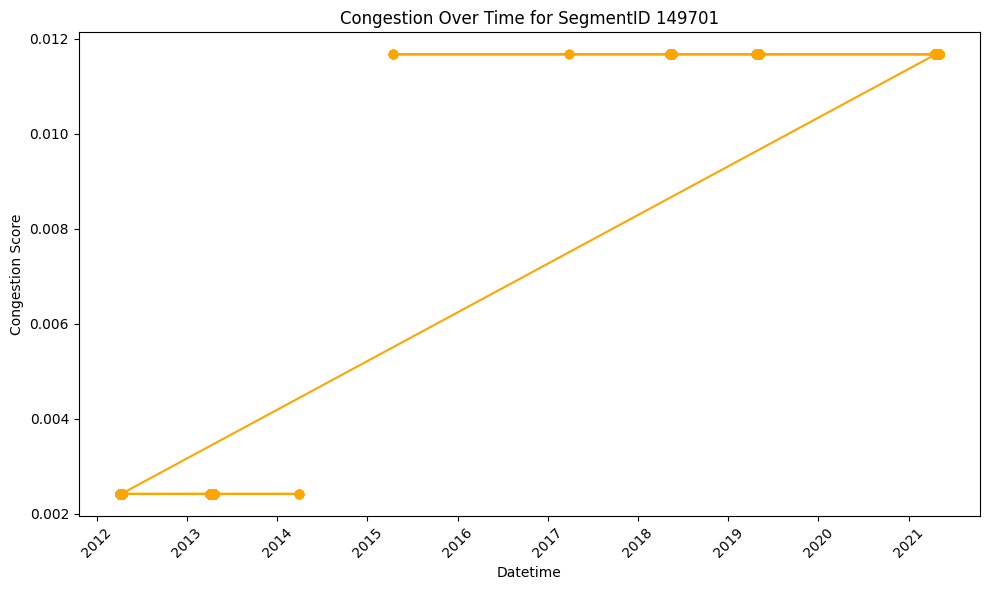

In [ ]:

segment_filter = segment_df[segment_df['SegmentID'] == 149701]

# Ploting congestion over time
plt.figure(figsize=(10, 6))
plt.plot(segment_filter['Datetime'], segment_filter['CongestionScore'], marker='o', color='orange')
plt.xlabel('Datetime')
plt.ylabel('Congestion Score')
plt.title(f'Congestion Over Time for SegmentID 149701')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


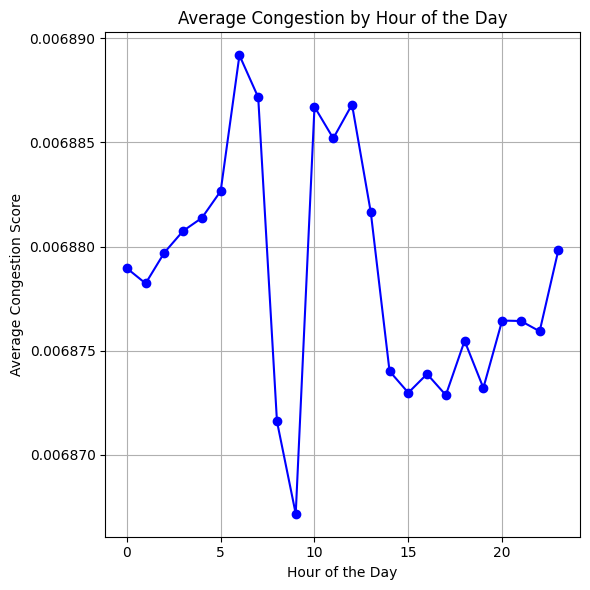

In [ ]:
segment_df['hour'] = segment_df['Datetime'].dt.hour
avg_congestion_by_hour = segment_df.groupby('hour')['CongestionScore'].mean()

plt.figure(figsize=(6, 6))
plt.plot(avg_congestion_by_hour.index, avg_congestion_by_hour.values, marker='o', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Congestion Score')
plt.title('Average Congestion by Hour of the Day')
plt.grid(True)
plt.tight_layout()
plt.show()


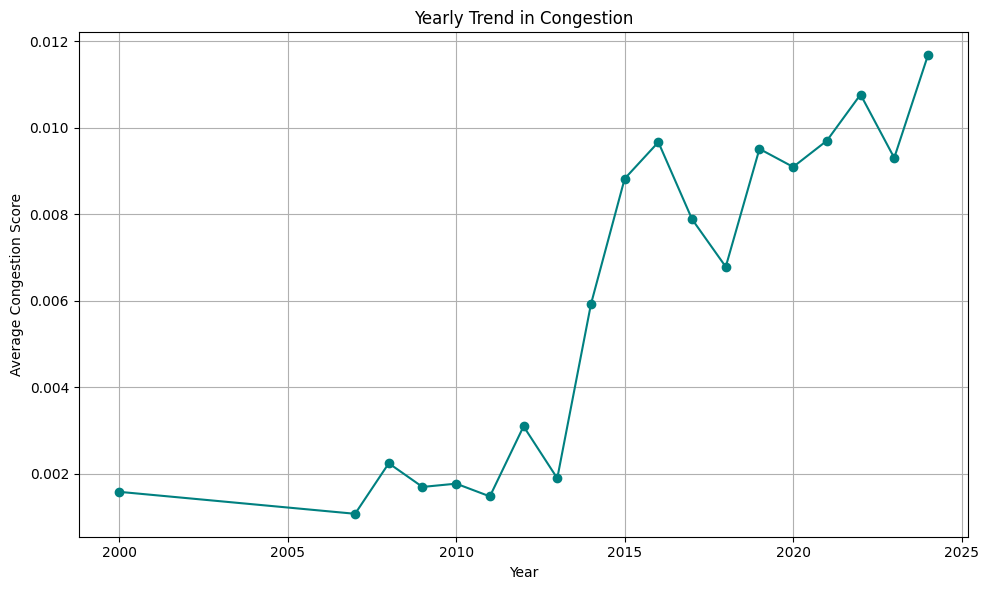

In [ ]:
segment_df['year'] = segment_df['Datetime'].dt.year
avg_congestion_by_year = segment_df.groupby('year')['CongestionScore'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_congestion_by_year.index, avg_congestion_by_year.values, marker='o', color='teal')
plt.xlabel('Year')
plt.ylabel('Average Congestion Score')
plt.title('Yearly Trend in Congestion')
plt.grid(True)
plt.tight_layout()
plt.show()
